<a href="https://colab.research.google.com/github/gregory-m-mullen/logp_graph_conv/blob/main/logp_graph_conv_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Convolutional Neural Network for Predicting logP of Molecules

This notebook sets up a graph convolutional neural network and uses it to predict the solubility parameter (logP) of a molecule from it's molecular structure. It uses the RDKit (https://www.rdkit.org/docs/Overview.html#what-is-it) and DeepChem (https://deepchem.io/about) libraries to represent molecules as graphs and uses Keras to build and train the network for predicting logP given a molecule's structure.

We are going to use DeepChem to develop and train the network. The module needs to be installed on the server we connect to.

In [1]:
!pip install --pre deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.1/812.1 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 52.1 MB/s eta 0:00:00


## Import/Preprocess Data

The data set we are going to use is a list of SMILES (https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) strings of molecules along with their corresponding logP values. The data set is huge, so we split it into 100 dataframes that we use for training and testing the model in batches.

In [2]:
%matplotlib inline
import pandas as pd
import deepchem as dc
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow import keras
import requests

In [3]:
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [4]:
file_id = '1k1_o39n5UOAKr1ESQfAdo5hopAgyw33W'
destination = 'smiles_mw_logp.csv'
download_file_from_google_drive(file_id, destination)

df_all = pd.read_csv(
    'smiles_mw_logp.csv',
    index_col='smiles'
    ).sample(frac=1, random_state=2)

## Define Model

This function converts each SMILES string in a database to a graph and sets up the data for processing through the network.

In [5]:
def define_dataset(df, test_size):
  df['mol_from_smiles'] = df.index.values
  df['mol_from_smiles'] = df['mol_from_smiles'].apply(lambda x: Chem.MolFromSmiles(x))
  df = df[~df['mol_from_smiles'].isnull()]

  featurizer = dc.feat.graph_features.ConvMolFeaturizer()
  features = [featurizer._featurize(x) for x in df.mol_from_smiles.values]

  df = df.drop(['mol_from_smiles'], axis=1)

  features_train, features_test, targets_train, targets_test = train_test_split(features, df, test_size=test_size, random_state=2)

  return features_train, features_test, targets_train, targets_test

In [6]:
features_train, features_test, targets_train, targets_test = define_dataset(df_all,test_size=0.1)

I've played around with the architecture of the network to try to determine what is optimum. In general, modeling logP with a graph convolutional network appears to be quite easy and doesn't require deep learning. The results were very accurate even with a relatively small network. Here, I show results using a single graph convolution layer with 101 neurons and one dense layer with 100 neurons. Larger models might work better if trained for more epochs. Ultimately the accurracy needed would depend on the application. Since this is for demonstration only, I was satisfied with the accuracy I got using small networks.

In [7]:
def build_model(n_tasks, n_conv=1, kernel_size=1001, dens_size=100):
  model = dc.models.graph_models.GraphConvModel(
      n_tasks,
      mode='regression',
      dropout=0.2,
      graph_conv_layers = [kernel_size for x in range(n_conv)],
      dense_layer_size = dens_size,
      batch_size = 1000,
      learning_rate = dc.models.optimizers.ExponentialDecay(3e-4, 0.9, 5000),
  )
  return model

## Train Model

In [8]:
metrics = [
           dc.metrics.Metric(dc.metrics.mean_squared_error),
           dc.metrics.Metric(dc.metrics.pearson_r2_score)
           ]

kernel_sizes = [1001]
n_convs = [1]
dens_sizes = [100]
EPOCHS = 200
test_size = 0.1
n_tasks = 1

features_train, features_test, targets_train, targets_test = define_dataset(df_all, test_size)
dataset_train = dc.data.NumpyDataset(X=features_train, y=targets_train)
dataset_test = dc.data.NumpyDataset(X=features_test, y=targets_test)

for kernel_size in kernel_sizes:
  for n_conv in n_convs:
    for dens_size in dens_sizes:
      print(n_conv)
      print(kernel_size)
      print(dens_size)

      validation = dc.models.ValidationCallback(
          dataset_test,
          100,
          metrics,
      )

      model = build_model(n_tasks, n_conv=n_conv, kernel_size=kernel_size, dens_size=dens_size)

      callbacks = [validation]

      model.fit(dataset_train, nb_epoch=EPOCHS, callbacks=callbacks)

1
1001
100
Step 100 validation: mean_squared_error=0.251989 pearson_r2_score=0.00215928
Step 200 validation: mean_squared_error=0.336638 pearson_r2_score=0.00502443
Step 300 validation: mean_squared_error=0.317357 pearson_r2_score=0.0274412
Step 400 validation: mean_squared_error=0.252087 pearson_r2_score=0.122738
Step 500 validation: mean_squared_error=0.118873 pearson_r2_score=0.387604
Step 600 validation: mean_squared_error=0.0647508 pearson_r2_score=0.635152
Step 700 validation: mean_squared_error=0.0578805 pearson_r2_score=0.676039
Step 800 validation: mean_squared_error=0.0440264 pearson_r2_score=0.773362
Step 900 validation: mean_squared_error=0.0396293 pearson_r2_score=0.778333
Step 1000 validation: mean_squared_error=0.0383073 pearson_r2_score=0.793654
Step 1100 validation: mean_squared_error=0.0365987 pearson_r2_score=0.802798
Step 1200 validation: mean_squared_error=0.0392891 pearson_r2_score=0.808853
Step 1300 validation: mean_squared_error=0.0303744 pearson_r2_score=0.8302

## Analyze results

We can check out the parity plots for any of the train or test samples. I usually like to look at a few to get a sense of how good/bad the model is doing for various samples.

Test set accuracy: 0.9636127372156001


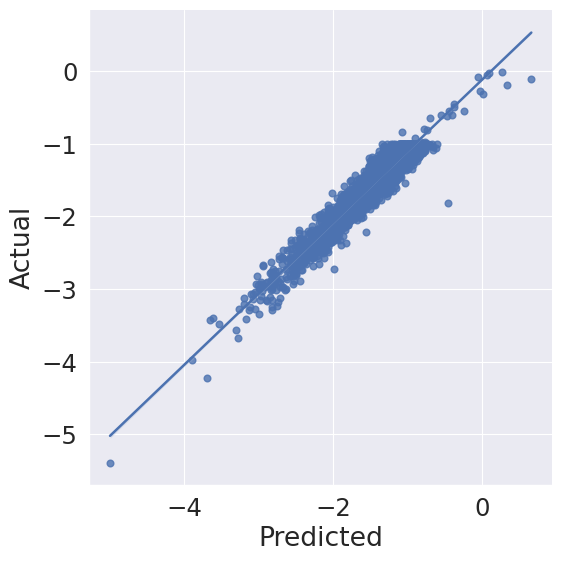

In [9]:
dataset_test = dc.data.NumpyDataset(X=features_test, y=targets_test)

df_plot = pd.DataFrame(columns=['Predicted','Actual'])
df_plot['Predicted'] = model.predict(dataset_test).flatten()
df_plot['Actual'] = targets_test['logp'].values

r2_test = str(df_plot.corr(numeric_only=True)['Actual']['Predicted'])

print ('Test set accuracy: ' + str(r2_test))

sns.set(context='paper', font_scale=2.0)
sns.lmplot(data=df_plot, x='Predicted', y='Actual', height=6)
plt.show()

Link to other machine learning techniques for modeling logP.